In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import os
import sys
from pathlib import Path
path = Path.cwd()
input_dir = path.parent
import cv2
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


#### Configuration

In [2]:
train_dir = input_dir/'train'
test_dir = input_dir/'test'
checkpoint_dir = input_dir/"experiment/checkpoint"
checkpoint_path = checkpoint_dir/"fasterrcnn_resnet50_fpn_200_rpn_epoch_29_.pth"
cfg = {}

#### Utils function

In [29]:
def get_bboxes_areas(row_box):
    bbox = np.fromstring(row_box[1:-1], sep=",")
    x, y, w, h = bbox
    return x, y, x+w, y+h, w, h, w*h

def show_boxes(img_id, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    image_path = os.path.join(train_dir, img_id+'.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = df.loc[df.image_id==img_id, ["xmin", "ymin", "xmax", "ymax"]].values
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    ax.imshow(image)
    
def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values

def show_prediction(valid_df, image_id):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    boxes = valid_df.loc[image_id,"boxes"]
    if isinstance(boxes, str):
        boxes = np.fromstring(boxes[1:-1], sep=",")
        print(boxes)
    gts = df.loc[df.image_id==image_id, ["xmin", "ymin", "xmax", "ymax"]].values
    image = cv2.imread(os.path.join(train_dir, image_id+".jpg"), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    #image = cv2.resize(image, (512, 512))
    for i, box in enumerate(boxes):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    for box in gts:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    ax.imshow(image)

class GlobalWheatDataset(Dataset):
    def __init__(self, df, image_ids, data_dir, transforms, train=True):
        self.df = df
        self.image_ids = image_ids
        self.data_dir = data_dir
        self.transforms = transforms
        self.train = train
    
    def __len__(self,):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        filename = image_id + ".jpg"
        image_path = os.path.join(self.data_dir, filename)
        image = self.load_image(image_path)
        if self.train:
            bboxes_areas = self.df[self.df.image_id==image_id][["xmin", "ymin", "xmax", "ymax", "area"]].values#.astype(np.float)
            #bboxes_areas = torch.as_tensor(bboxes_areas, dtype=torch.float32)  
            bboxes = bboxes_areas[:, :-1]
            area = torch.as_tensor(bboxes_areas[:, -1])
            labels = torch.ones(len(bboxes), dtype=torch.int64)
            image_id = torch.as_tensor([index], dtype=torch.int64)
            iscrowd = torch.zeros(len(bboxes_areas), dtype=torch.uint8)
            
            target = {"boxes": bboxes,
                      "labels": labels,
                      "image_id": image_id,
                      "area": area,
                      "iscrowd": iscrowd,
                      }
            sample = self.transforms(**{"image": image,
                                        "bboxes": bboxes,
                                        "labels": labels})
         
            
            bboxes = torch.as_tensor(sample["bboxes"], dtype=torch.float32).reshape(-1, 4)
            target["boxes"] = bboxes
            image = sample["image"]
            return image, target, filename
        
        else:
            sample = self.transforms(**{"image": image})
            return sample["image"], image_id
        
    
    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         image = Image.open(image_path).convert("RGB")
        return image

def get_train_transforms():
    return A.Compose(
        [
             A.RandomSizedCrop(min_max_height=(400, 400), height=1024, width=1024, p=0.5),

            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=1024, width=1024, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_test_transforms():
    return A.Compose(
        [
             A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0,
    )


def collate_fn(batch):
    sample = tuple(zip(*batch))
    return sample

train_transforms = get_train_transforms()
valid_transforms = get_valid_transforms()
test_transforms = get_test_transforms()

def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values

def get_train_valid_dataloaders(fold):
    train_idx, valid_idx = get_train_val_indexes(folds_df, fold)
    
    train_dataset = GlobalWheatDataset(df, train_idx, train_dir, train_transforms, train=True)
    valid_dataset = GlobalWheatDataset(df, valid_idx, train_dir, valid_transforms, train=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

    return train_dataloader, valid_dataloader

def get_test_dataloader():
    test_dataset = GlobalWheatDataset(test_df, test_df.image_id.unique(), test_dir, test_transforms, train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=10, num_workers=4)
    return test_dataloader


#### Mix images

In [30]:
def merge_targets(target1, target2):
    targets = []
    for i in range(len(target1)):
        target = dict()
        for key in target1[i].keys():
            merged_value = torch.cat([target1[i][key], target2[i][key]])
            target[key] = merged_value
        targets.append(target)
    return tuple(targets)

def mixup_images(images1, images2):
    mixed_images = [0.5 * (images1 + images2) for (images1, images2) in zip(images1, images2)]
    return tuple(mixed_images)

#### Load DataFrames

In [31]:
df = pd.read_csv(input_dir/'train.csv')
test_df = pd.read_csv(input_dir/"sample_submission.csv")
valid_df = pd.read_csv("validation.csv")

In [32]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1
df['w'] = -1
df['h'] = -1
df['area'] = 0
df[['xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'area']] = np.stack(df['bbox'].apply(lambda row_box: get_bboxes_areas(row_box)))
df.drop(columns=["bbox"], inplace=True)
df.head(1)

,image_id,width,height,source,xmin,ymin,xmax,ymax,w,h,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,890.0,258.0,56.0,36.0,2016.0


In [33]:
%time
folds_df = df.groupby(["image_id", "source"])["source"].count().to_frame(name="bbox_count").reset_index()
folds_df['stratify_group'] = np.char.add(folds_df["source"].values.astype(str), folds_df['bbox_count'].apply(lambda x: f'_{x // 20}').values.astype(str))
folds_df['mean_area'] = df.groupby(["image_id"])["area"].mean().values
folds_df['std_area'] = df.groupby(["image_id"])["area"].std().values
folds_df['fold'] = 0
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
for fold, (train_index, test_index) in enumerate(skf.split(folds_df, folds_df.stratify_group)):
    folds_df.loc[test_index, 'fold'] = fold
folds_df.head(1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,image_id,source,bbox_count,stratify_group,mean_area,std_area,fold
0,00333207f,arvalis_1,55,arvalis_1_2,6375.381818,4341.766616,4


#### Visualize Images

In [36]:
train_transforms = get_train_transforms()
train_dataloader1, valid_dataloader1 = get_train_valid_dataloaders(0)
train_dataloader2, valid_dataloader2 = get_train_valid_dataloaders(0)
data_iter = zip(iter(train_dataloader1), iter(train_dataloader2))

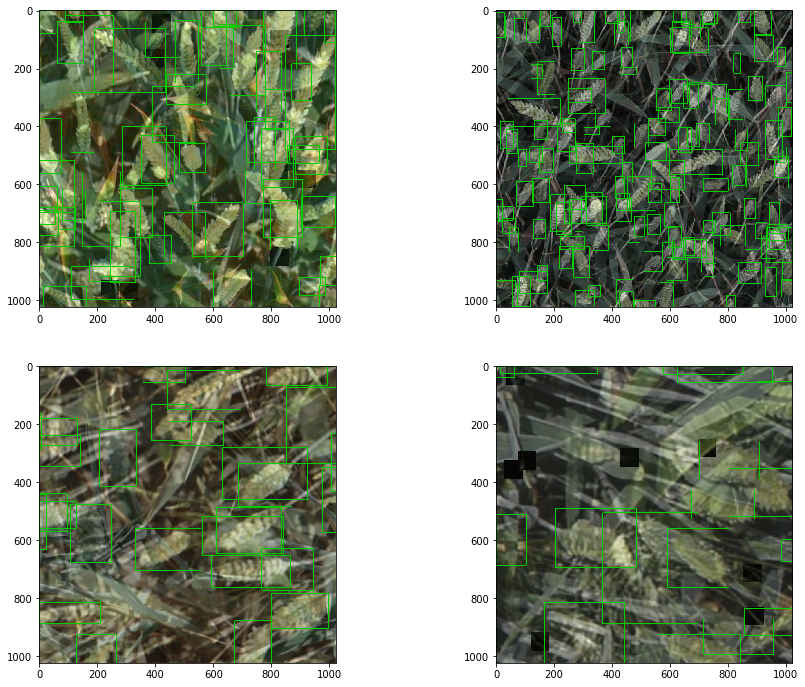

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.reshape(2*2)
batch1, batch2 = next(data_iter)
for i ,ax in enumerate(axes):
    images1, target1, imge_ids1 = batch1
    images2, target2, imge_ids2 = batch2
    images = mixup_images(images1, images2)
    target = merge_targets(target1, target2)
    image = images[i].permute(1, 2, 0).numpy().copy()
    bboxes = target[i]["boxes"]
    for box in bboxes:
        box = np.array(box).astype(int)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, .8, 0), 2)
    ax.imshow(image)
    image = np.round(image*255)
    cv2.imwrite(f"image{i}.jpg", image)